<a href="https://colab.research.google.com/github/gurpreetschohan/CongressionalNotebook/blob/main/CongressionalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis comparing the relationship between the 116th Congressional Districts Party Affiliation and Total Median Age

Max Rodriguez (arodr395@calpoly.edu)
Solomon Zhou (szhou11@calpoly.edu)
Gurpreet Chohan (gchohan@calpoly.edu)

February 9th, 2023


This analysis is exploring the relationship between age and political affiliation. We gathered the total median age within the 116th Congressional Districts in the United States. This analysis explores the trends of how younger and older generations' political beliefs are either similar or different.

Pre-Analysis Prediction: 
We predict Democratic districts will have a lower median age compared to Republican districts. We believe that younger generations tend to be more liberal and align more with the Democratic Party. While older generations are more traditional, conservative, and their beliefs align with the Republican Party. 



In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd
import folium
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import seaborn as sns

----------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------

#**Gathering District data from Census** 

----------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------

First we will read the ACS 2021 dataset and get it into a usable state for our data analysis.

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B01002_001E,B01002_002E,B01002_003E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in
# ata
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Median Age', 'Male Median Age', 'Female Median Age','State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Median Age', 'Male Median Age', 'Female Median Age','district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

#CITE: https://www.census.gov/data/academy/webinars/2022/back-to-data-basics-series/data-for-congressional-and-state-legislative-districts.html

,Total Median Age,Male Median Age,Female Median Age,district number,State
0,41.1,39.4,42.6,1,Alabama
1,39.2,37.9,40.7,2,Alabama
2,39.4,38.4,40.2,3,Alabama
3,40.7,39.5,42.0,4,Alabama
4,40.3,39.6,41.1,5,Alabama


----------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------

#**Transforming Data and Cleaning Data** 

----------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------

In [ ]:

# Convert the number columns into number data types so we can math on them
acs_df['Total Median Age'] = pd.to_numeric(acs_df['Total Median Age'])
acs_df['Male Median Age'] = pd.to_numeric(acs_df['Male Median Age'])
acs_df['Female Median Age'] = pd.to_numeric(acs_df['Female Median Age'])

# now let's look at the data again
acs_df.head()

,Total Median Age,Male Median Age,Female Median Age,district number,State
0,41.1,39.4,42.6,1,Alabama
1,39.2,37.9,40.7,2,Alabama
2,39.4,38.4,40.2,3,Alabama
3,40.7,39.5,42.0,4,Alabama
4,40.3,39.6,41.1,5,Alabama


Now let's get our party affiliation data in a state to merge with the ACS data.

In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])
# Removes Libertarian, not enough data
merged_df.drop(merged_df[(merged_df['Party'] == "L")].index, inplace=True)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------

#**Visualizations and Analysis**

----------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------

The boxplot with jitter illustrates the overall distribution of the Total Median Age between Repulican and Democrat districts. The total ages of all Republican districts has a higher median compared to the total ages of all Democrat districts. The jitter represents single data points. The Total Median Age of Republican districts has a larger spread and a few outliers. 

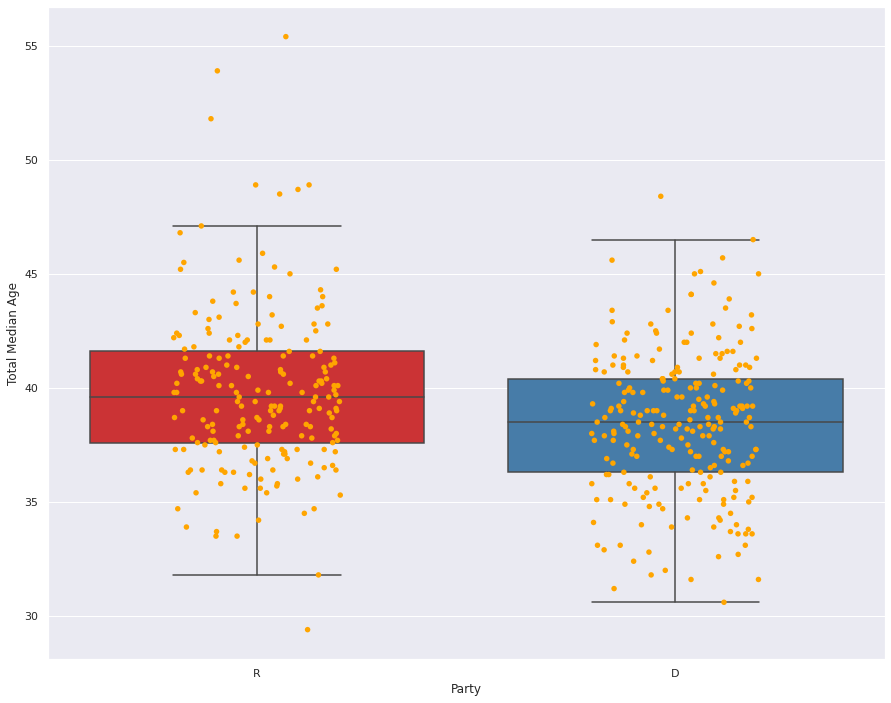

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
ax = sns.boxplot(x='Party', y='Total Median Age', data=merged_df, ax=ax,palette="Set1",showfliers=False)
ax = sns.stripplot(x='Party', y='Total Median Age', data=merged_df, color="orange", jitter=0.2, size=5.5, ax=ax)
# show the graph
plt.show()

To better understand the outliers, we looked at Total Median Age that fall outside the Interquartile Range. The outliers mostly come from Florida. Florida is predominantly a Repuplican state which validates why Republican districts have outliers. A few other outliers comes from Repulican districts in Arizona and Utah.

In [ ]:
Q3 = np.percentile(merged_df['Total Median Age'], 75,interpolation = 'midpoint')
IQR = Q3 - Q1
upper = merged_df[merged_df["Total Median Age"] >= (Q3+1.5*IQR)]
upper

,Total Median Age,Male Median Age,Female Median Age,district number,State,Party
11,48.5,46.2,49.9,4,Arizona,R
92,48.9,46.9,50.5,6,Florida,R
94,48.9,46.6,50.5,8,Florida,R
97,55.4,53.4,57.1,11,Florida,R
99,48.4,46.9,49.7,13,Florida,D
102,46.8,44.7,48.9,16,Florida,R
103,53.9,52.5,55.1,17,Florida,R
104,48.7,47.1,50.0,18,Florida,R
105,51.8,50.7,52.8,19,Florida,R
198,47.1,45.2,48.6,1,Michigan,R


In [ ]:
Q1 = np.percentile(merged_df['Total Median Age'], 25,interpolation = 'midpoint')
IQR = Q3 - Q1
lower = merged_df[merged_df["Total Median Age"] <= (Q1-1.5*IQR)]
lower

,Total Median Age,Male Median Age,Female Median Age,district number,State,Party
41,30.6,30.8,30.3,21,California,D
399,29.4,28.9,30.2,3,Utah,R


Two Sided T-Test

Null Hypothesis (H0): Total Median Age of Republican and Democrat districts are equal.

Alternative Hypothesis (Ha): Total Median Age of Republican and Democrat districts are not equal.

Since the P-Value(.00001732332) is less than alpha(.05), we reject the Null Hypothesis. Hence, there is a statistically significant difference in Total Median Age of Republican and Democrat districts. 

In [ ]:
R = merged_df[merged_df["Party"]=='R']
D = merged_df[merged_df["Party"]=='D']

t_stat, p_value = ttest_ind(R['Total Median Age'], D['Total Median Age'])
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  4.345742592304067
P-Value:  1.7323317835856412e-05


This graph shows that the Republicans have a higher densites among it's districts for the ages of around **40 to 60**. While Democrats have higher densities among its districts for the ages of around **27 to 40**. The graph also shows that around the age of 50 their are no more democratic counties with that average median age. 

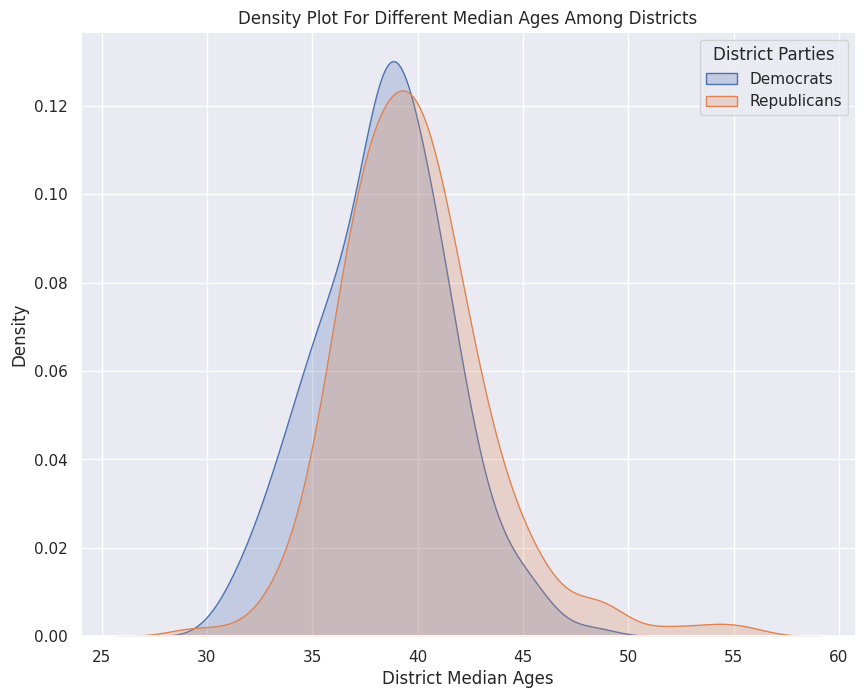

In [ ]:
 from matplotlib.pyplot import figure
 figure(figsize=(10, 8), dpi=100)
 
 Democrats_Age = merged_df[(merged_df.Party =="D")]
 Democrats_All_Ages = Democrats_Age['Total Median Age']

 Rebublicans_Age = merged_df[(merged_df.Party =="R")]
 Rebublicans_All_Ages = Rebublicans_Age['Total Median Age']

# create data
values1 =(Democrats_All_Ages)
values2 =(Rebublicans_All_Ages)


# set a grey background 
sns.set(style="darkgrid")
df = sns.load_dataset('iris')

sns.kdeplot(values1, shade=True)
sns.kdeplot(values2, shade=True)
plt.xlabel('District Median Ages')
plt.title('Density Plot For Different Median Ages Among Districts')
plt.legend(["Democrats","Republicans"],title = "District Parties")

plt.show()


looking into the states by age we find that 8 out of the top 10 oldest districts are in Florida and only one of them is Democratic. 

In [ ]:
merged_df.sort_values(by='Total Median Age', ascending=False)


,Total Median Age,Male Median Age,Female Median Age,district number,State,Party
97,55.4,53.4,57.1,11,Florida,R
103,53.9,52.5,55.1,17,Florida,R
105,51.8,50.7,52.8,19,Florida,R
94,48.9,46.6,50.5,8,Florida,R
92,48.9,46.9,50.5,6,Florida,R
...,...,...,...,...,...,...
400,31.6,31.3,32.0,4,Utah,D
393,31.6,32.0,31.3,33,Texas,D
14,31.2,31.0,31.4,7,Arizona,D
41,30.6,30.8,30.3,21,California,D


<Figure size 1000x800 with 0 Axes>

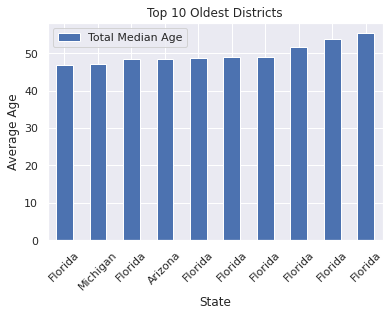

In [ ]:
#figure(figsize=(10, 8), dpi=100)

df_sorted = merged_df.sort_values(by='Total Median Age', ascending=False)

top_10 = df_sorted.head(10)

top_10.plot(x='State', y='Total Median Age', kind='bar', rot=45)
plt.xlabel('State')
plt.ylabel('Average Age')
plt.title('Top 10 Oldest Districts')
plt.gca().invert_xaxis()
plt.show()

In [ ]:
grouped = merged_df.groupby("State")["Total Median Age"].mean()
grouped = grouped.reset_index()
grouped = grouped.rename(columns={"Total Median Age": "Median Age"})
states_age = pd.DataFrame(grouped, columns=["State", "Median Age"])

states_age = states_age.astype({"State": object, "Median Age": float})


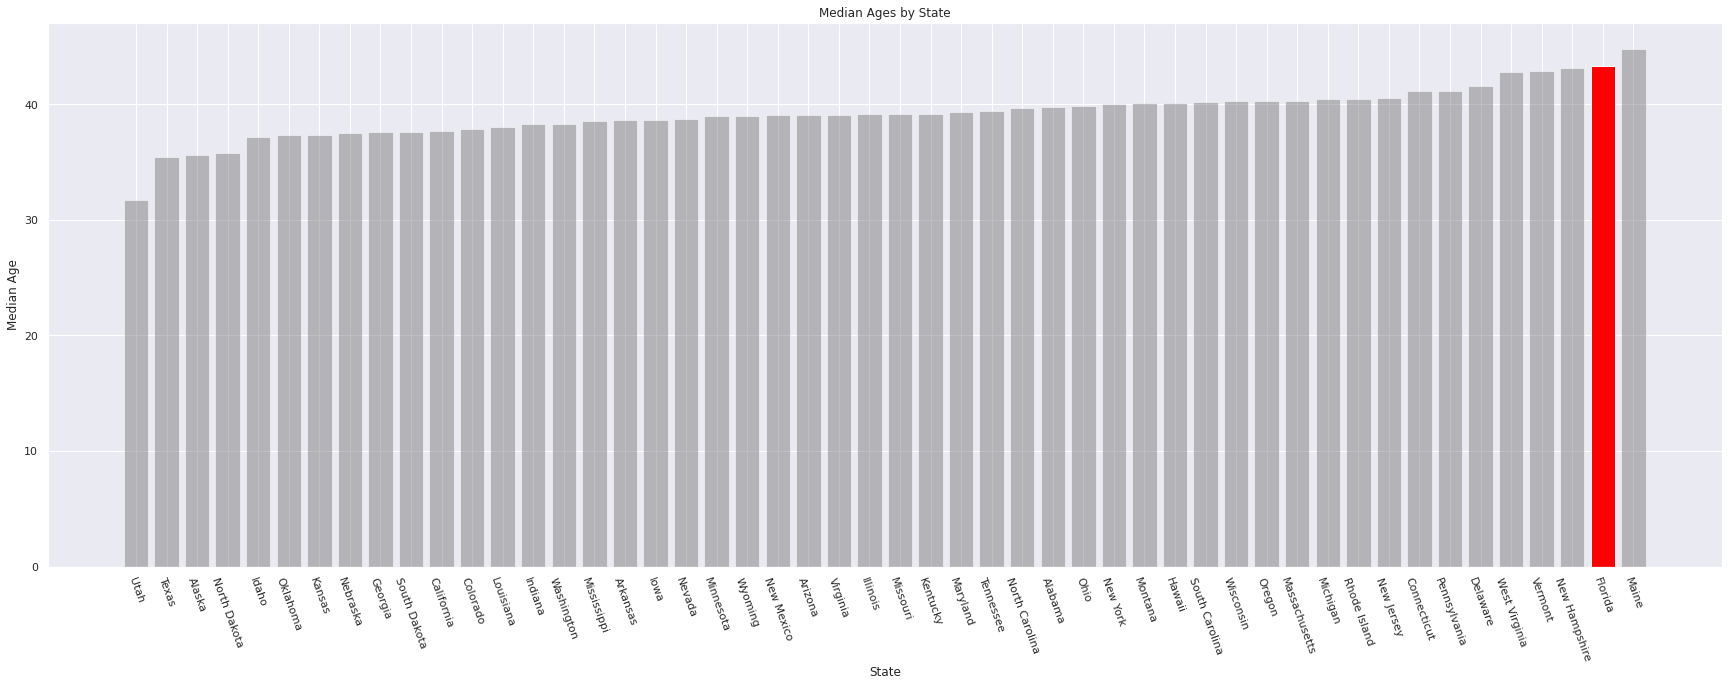

In [ ]:
plt.figure(figsize=(30,10))

states_age.sort_values(by='Median Age', ascending=True, inplace=True)
states = states_age['State']
median_ages = states_age['Median Age']

plt.bar(states, median_ages, alpha=0.5, color='gray')

state_names = ['Florida']
index = [i for i in range(len(states)) if states[i] in state_names]
color = 'red'
for i in index:
    plt.bar(states[i], median_ages[i], color=color)

plt.xlabel('State')
plt.ylabel('Median Age')
plt.title('Median Ages by State')

plt.xticks(rotation=-70)
# Show the plot
plt.show()

This map shows the percentage of eacch states populatio over the age of 65. Here we can clearly see that Florida is very deep red indicating that it has a high population over the age of 65.



*   We know that their is a statistical difference between the ages among democratic and republican districts.
*   After identifying the outliers among republican disticts the majority are in Florida. 
* Florida is a very popular retirment destination because of it's lax tax laws and great weather. 
*   Florida in general has a very high concentration of people over the age of 65. This explains why the outliers exist and may also be a key reason as to why republicans skew towards the older demographics may be more prevalent. 



In [ ]:
import requests

from google.colab import drive
drive.mount('/content/drive')

state_population = pd.read_excel('/content/drive/My Drive/Colab Notebooks/States Ranked by Percent of Population Age 65 or Older, 2020.xlsx')

url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
state_geo = f"{url}/us-states.json"

m = folium.Map(location=[37, -102], zoom_start=4)

#choropleth map
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_population,
    columns=["Abbreviations", "Population Ages 65+ (percent of state population)"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.1,
    legend_name="Percent of population over the age of 65"
).add_to(m)

folium.LayerControl().add_to(m)

m

#CITE: https://www.prb.org/resources/which-us-states-are-the-oldest/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------

#**Appendix**

----------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------

The following two boxplots help visualize the Total Median Age of Female and Male for Republican and Democrat districts. It shows that regardless of Female or Male, Republican districts still have a larger Total Median Age and distribution compared to Democrat districts. 

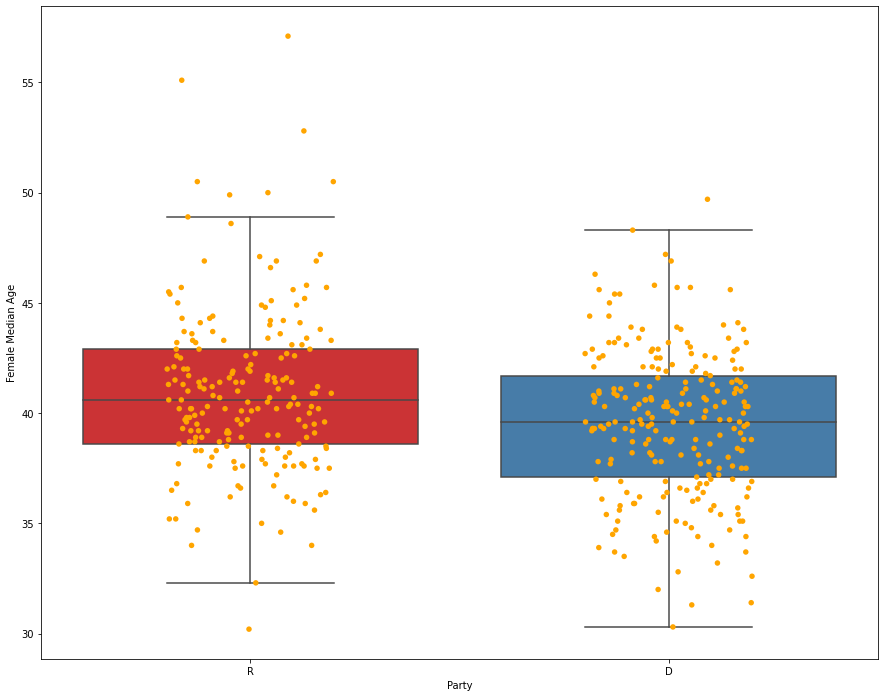

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
ax = sns.boxplot(x='Party', y='Female Median Age', data=merged_df, ax=ax,palette="Set1",showfliers=False)
ax = sns.stripplot(x='Party', y='Female Median Age', data=merged_df, color="orange", jitter=0.2, size=5.5, ax=ax)
# show the graph
plt.show()

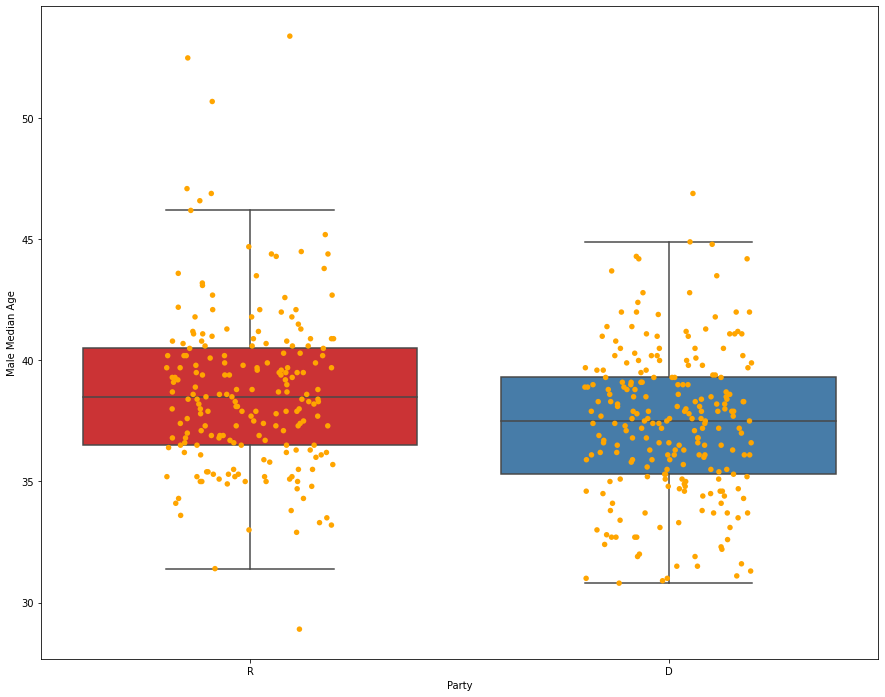

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
ax = sns.boxplot(x='Party', y='Male Median Age', data=merged_df, ax=ax,palette="Set1",showfliers=False)
ax = sns.stripplot(x='Party', y='Male Median Age', data=merged_df, color="orange", jitter=0.2, size=5.5, ax=ax)
# show the graph
plt.show()